### Imports

In [97]:
import pandas as pd
import networkx as nx
import numpy as np

import random
%matplotlib inline
#%config InlineBackend.figure_formats = ['retina']

'''algo collected from https://github.com/hhchen1105/networkx_addon.git'''
from networkx_addon.information_propagation import linear_threshold, independent_cascade

import seaborn as sns

import matplotlib.pyplot as plt
import math
import json
import datetime

from collections import defaultdict

import dask
import dask.dataframe as dd
from dask import threaded, multiprocessing
number_of_process = 4

from scipy.stats import poisson
import soil
from soil.analysis import *

from dask import delayed
import dask.dataframe as dd
import dask
import os.path
import dask.bag as db

import logging

sns.set()
sns.set_context('paper')

### Installing SOIL for simulation

Simulations are done using the SOIL package

Instal soil using the following command in the notebook

```
!pip install soil
```

more details avalialbe in [https://github.com/gsi-upm/soil](https://github.com/gsi-upm/soil)

### Initial Reads

In [2]:
ldbc_50 = "datasets/LDBC_50/person_knows_person_0_0.csv"

In [3]:
ldbc_200 = "datasets/LDBC_200/person_knows_person_0_0.csv"
edge_list_200 = pd.read_csv(ldbc_200, sep='|', names=['src', 'dst', 'date'], skiprows=1)
net200 = nx.from_pandas_edgelist(edge_list_200, source = 'src', target='dst')

In [12]:
edge_list = pd.read_csv(ldbc_50, sep='|', names=['src', 'dst', 'date'], skiprows=1)

In [13]:
net50 = nx.from_pandas_edgelist(edge_list, source = 'src', target='dst')

In [27]:
nx.write_gexf(network, "datasets/LDBC_50/network.gexf")

In [111]:
nx.write_gexf(net200, "datasets/LDBC_200/network.gexf")

In [10]:
nx.draw_spring(network)

### Example how soil works

In [201]:
import random

class NewsSpread(soil.agents.FSM):
    @soil.agents.default_state
    @soil.agents.state
    def neutral(self):
        r = random.random()
        if self['has_tv'] and r < self.env['prob_tv_spread']:
                return self.infected
        return
    
    @soil.agents.state
    def infected(self):
        prob_infect = self.env['prob_neighbor_spread']
        for neighbor in self.get_neighboring_agents(state_id=self.neutral.id):
            r = random.random()
            if r < prob_infect:
                neighbor.state['id'] = self.infected.id
        return

In [202]:
NEIGHBOR_FACTOR = 0.5
TV_FACTOR = 0.2
class NewsEnvironmentAgent(soil.agents.BaseAgent):
    def step(self):
        if self.now == self['event_time']:
            self.env['prob_tv_spread'] = 0.1
            self.env['prob_neighbor_spread'] = 0.2
        elif self.now > self['event_time']:
            self.env['prob_tv_spread'] = self.env['prob_tv_spread'] * TV_FACTOR
            self.env['prob_neighbor_spread'] = self.env['prob_neighbor_spread'] * NEIGHBOR_FACTOR

In [66]:
config = {
    'name': 'ExternalInfluenceSimulation',
    'max_time': 2000,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'path': "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/LDBC_50/network.gexf"
    },
    'network_agents': [
        {
            'agent_type': NewsSpread,
            'weight': 1,
            'state': {
                'has_tv': False
            }
        },
        {
            'agent_type': NewsSpread,
            'weight': 2,
            'state': {
                'has_tv': True
            }
        }
    ],
    'environment_agents':[
        {'agent_type': NewsEnvironmentAgent,
         'state': {
             'event_time': 10
         }
        }
    ],
    'states': [{2199023255557: {'has_tv': True}}, 
               {41: {'has_tv': True}}, 
               {6597069766660: {'has_tv': True}}],
    'environment_params':{
        'prob_tv_spread': 0.01,
        'prob_neighbor_spread': 0.05
    }
}

In [ ]:
soil.simulation.run_from_config(config, dump=False)

In [54]:
!tree soil_output
!du -xh soil_output/*

/bin/sh: 1: tree: not found
12K	soil_output/ExampleSimulation/.ipynb_checkpoints
48K	soil_output/ExampleSimulation
92K	soil_output/ExternalInfluenceSimulation


In [ ]:
plot_all('soil_output/ExternalInfluenceSimulation*', get_count, 'id')

In [ ]:
soil.agents.IndependentCascadeModel

### Read Network

In [5]:
net50 = nx.read_gexf("datasets/LDBC_50/network.gexf")
print(nx.info(net50))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 74
Average degree:   4.2286


In [153]:
net200 = nx.read_gexf("datasets/LDBC_200/network.gexf")
print(nx.info(net200))

Name: 
Type: Graph
Number of nodes: 148
Number of edges: 604
Average degree:   8.1622


### Simulation 1: Information Diffusion with global $P_i$ and $P_e$

In [37]:
import logging

'''This class written for simulating PotHole with global values of $P_i$ and $P_e$'''
class PotHole(soil.agents.FSM):
    
    @soil.agents.default_state
    @soil.agents.state
    def idle(self):
        r = random.random()
        if self['has_ext'] and r < self.env['prob_tv_spread']:
            self.src = -1
            self.tag = "#Football"
            return self.tweet
        return
    
    @soil.agents.state
    def tweet(self):
        self.state['tag'] = self.tag
        self.state['src'] = self.src
        for neighbor in self.get_neighboring_agents():
            neighbor.tag = self.tag
            neighbor.src = self.id
            neighbor.state['id'] = self.tweet_recv.id
        return self.idle
    
    @soil.agents.state
    def tweet_recv(self):
        prob_infect = self.env['prob_neighbor_spread']
        r = random.random()
        if r < prob_infect:            
            return self.tweet
        return self.idle

Writing PotHole.py


In [3]:
config1 = {
    'name': 'PH5',
    'max_time': 2000,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'path': "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/LDBC_200/network.gexf"
    },
    'network_agents': [
        {
            'agent_type': PotHole,
            'weight': 9,
            'state': { 'has_ext': 0 }
        },        
        {
            'agent_type': PotHole,
            'weight': 1,
            'state': {'has_ext' : 1 }
        }
    ],
    'environment_agents': [],
    'environment_params':{
        'prob_tv_spread': 0.5,
        'prob_neighbor_spread': 0.5
    }
}

In [ ]:
soil.simulation.run_from_config(config1, dump=['gexf', 'csv'])

In [ ]:
!tree soil_output
!du -xh soil_output/*

In [25]:
df1 = pd.read_csv("soil_output/PH_e0.400_i0.600/PH_e0.400_i0.600_trial_0.environment.csv",dtype={'agent_id': str})

In [10]:
df1[df1.key == 'prob_neighbor_spread'].value.iloc[0]

'0.95'

#### Process_Simulation

In [58]:
df = pd.DataFrame()

In [59]:
df.drop()

'0.20.3'

In [60]:
def process_simulation(df1):
    env = df1[df1.agent_id == 'env'].copy()
    tags = df1[df1.key == 'tag']
    status = df1[df1.key == 'id']
    src = df1[df1.key == 'src']

    dfi = tags.merge(status, on=['agent_id', 't_step'], how='inner')
    dfr = dfi.merge(src, on=['agent_id', 't_step'], how='inner')
    dfr.drop(labels=['key_x', 'key_y', 'key', 'value_type_x', 'value_type_y', 'value_type'], axis=1, inplace=True)
    dfr.columns = ['user_id', 'ts', 'hashtag', 'status', 'src']
    return (env, dfr)

#### Split the results into slots for further processing

In [10]:
%%time

def split_into_slots(time_slice, start, end, ds, net):

    min = start
    max = min + time_slice

    slotid = 1

    data = []

    while min < end:    
        events = ds[(ds.ts >= min) & (ds.ts < max)]
    
        #posted_tags = {}
        p_kn_tag_count = defaultdict(int)
        known_tag = {}
        inbound_p_count = defaultdict(int)

        for index, row in events.iterrows():
            #posted_tags.setdefault(row.user_id, list()).append(row.hashtag)

            if(row.src != '-1'):
                p_kn_tag_count[row.user_id] += 1

            try:                
                for n in net.neighbors(str(row.user_id)):
                    inbound_p_count[n] += 1
            except KeyError:
                continue

        posted_tag_counts = events.groupby(by="user_id").hashtag.count()
        for node in events.user_id.unique():
            p_tag_count = posted_tag_counts[node]
            p_k_tag_count = p_kn_tag_count[node]
            in_pulses_count = inbound_p_count[node]

            data.append([slotid, node, p_tag_count, p_k_tag_count, in_pulses_count])

        min = max
        max = min + time_slice

        slotid += 1
        
    return pd.DataFrame(data, columns=['slot_id', 'user_id', 'post_count', 'post_kn_count', 'total_pulses'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 27.7 µs


#### Membership

In [9]:
def ms_large(x, a, b, mean, sd):
    if(x > a*mean):
        return 1 - ((b*sd)/(x - a*mean + b*sd))
    else:
        return 0
    
def membership_mslarge(row, mr, sr, mg, sg):
    ratio = 0
    consumer = 0
    if row.total_pulses != 0:
        ratio = row.post_kn_count / row.total_pulses    
        consumer = ms_large(ratio, 0.2, 1, mr, sr)
    
    gw_post = row.post_count - row.post_kn_count    
    gateway = ms_large(gw_post, 1, 3, mg, sg)
    
    return pd.Series({'depth': consumer, 'width': gateway})

In [ ]:
%%time

daily_stat = split_into_slots(100, 0, 2000, cascade, net50)

In [64]:
ratio = daily_stat.post_kn_count/daily_stat.total_pulses
print(ratio.mean())
print(ratio.std())

0.143728445249
0.130020655027


In [66]:
gw_post_count = daily_stat.post_count - daily_stat.post_kn_count
print(gw_post_count.mean())
print(gw_post_count.std())

1.317617866
2.91903382824


In [71]:
stat_mem = daily_stat.groupby(by='user_id').mean()[['post_count', 'post_kn_count', 'total_pulses']]

In [74]:
stat_mem.reset_index(inplace=True)

In [81]:
x = stat_mem.apply(membership_mslarge, axis=1)
nodes_with_mem = pd.concat([stat_mem, x], axis=1)

In [ ]:
nodes_with_mem

In [ ]:
daily_stat

In [ ]:
xyz = daily_stat.apply(consumer_membership_mslarge, axis=1)
xyz.name = "consumer"
stats_mem = pd.concat([daily_stat, xyz], axis=1)

In [ ]:
plot_all('soil_output/PotholeX*', get_count, 'id')

In [103]:
d[d.hashtag != '#Football']

Empty DataFrame
Columns: [user_id, ts, hashtag, status, src]
Index: []

#### Analysis Simulation

In [6]:
def analyse_simulation(file, sn):    
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    
    env, cascade = process_simulation(df1)
    cascade = cascade.sort_values(by='ts')
    
    daily_stat = split_into_slots(100, 0, 2000, cascade, sn)
    
    ratio = daily_stat.post_kn_count/daily_stat.total_pulses
    ratio = ratio.replace([np.inf, -np.inf], np.nan)
    mr = ratio.mean()
    sr = ratio.std()
    
    print('{2} | mean: {0}; std: {1};'.format(mr, sr, file))
    
    gw_post_count = daily_stat.post_count - daily_stat.post_kn_count
    mg = gw_post_count.mean()
    sg = gw_post_count.std()
    
    print('mean: {0}; std: {1};'.format(mg, sg))
    
    stat_mem = daily_stat.groupby(by='user_id').mean()[['post_count', 'post_kn_count', 'total_pulses']]
    stat_mem.reset_index(inplace=True)
    
    x = stat_mem.apply(membership_mslarge, args=(mr, sr, mg, sg,), axis=1)
    nodes_with_mem = pd.concat([stat_mem, x], axis=1)
    
    return (env, df1[(df1.key == 'has_ext') & (df1.value == '1')].copy(), nodes_with_mem)

In [31]:
%%time
env, seed4, mem4 = analyse_simulation("soil_output/PH_e0.400_i0.600/PH_e0.400_i0.600_trial_0.environment.csv", net200)

soil_output/PH_e0.400_i0.600/PH_e0.400_i0.600_trial_0.environment.csv | mean: 0.33753084876851575; std: 0.24651717717997265;
mean: 0.5834186284544524; std: 3.0485465761702715;
CPU times: user 14.1 s, sys: 82 ms, total: 14.2 s
Wall time: 14.2 s


In [35]:
match_with_true4 = mem4.merge(seed4, left_on='user_id', right_on='agent_id', how='inner')

In [ ]:
match_with_true4.sort_values('width')

### Parameter space testing

1. $P_e$ from 0 to 1 with 0.25 interval
2. $P_i$ from 0 to 1 with 0.25 interval
3. with 10% random external influence

In [3]:
config1 = {
    'name': 'PH5',
    'max_time': 2000,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'path': "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/LDBC_200/network.gexf"
    },
    'network_agents': [
        {
            'agent_type': PotHole,
            'weight': 9,
            'state': { 'has_ext': 0 }
        },        
        {
            'agent_type': PotHole,
            'weight': 1,
            'state': {'has_ext' : 1 }
        }
    ],
    'environment_agents': [],
    'environment_params':{
        'prob_tv_spread': 0.5,
        'prob_neighbor_spread': 0.5
    }
}

#### Get all config
This is require for parallel execution

In [12]:
%%time
simulations = []
for ep in np.linspace(0,1,20,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'PH_e{0:.3f}_i{1:.3f}'.format(ep, ip)
        
        file = 'soil_output/{0}/{0}_trial_0.environment.csv'.format(name)
        df1 = pd.read_csv(file, dtype={'agent_id': str})
        if(df1[df1.key == 'prob_tv_spread'].value.iloc[0] 
           != df1[df1.key == 'prob_neighbor_spread'].value.iloc[0]):
            del df1
            continue
        #if(os.path.exists(file)):
        #    continue
                
    
        config1['name'] = name
        config1['environment_params'] = {'prob_tv_spread': float(ep), 
                                         'prob_neighbor_spread': float(ip)}       
        simulations.append(config1.copy())

CPU times: user 2min 12s, sys: 2.67 s, total: 2min 15s
Wall time: 2min 16s


In [25]:
# Checking if the configs are different to make sure everything run correctly
simulations[1] == simulations[4]

False

#### Multiprocessing
As soil creates lot of threads internally, we can not use Dask which use DaemonProcess. We need a customization for NoDaemonProcess as below

In [2]:
import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

In [3]:
def sim(cnf):
    soil.simulation.run_from_config(cnf, results_dir='soil_output/PHC', dump=['gexf', 'csv'])
    return 1

##### Running simulations in parallel 

In [ ]:
no_of_process = 8
p = MyPool(no_of_process)

p.map(sim, simulations)

p.close()
p.join()

##### Analysing results in parallel

In [54]:
def analysis200(file):
    env, seed, mem = analyse_simulation(file[0], net200)
    env.to_csv('{0}env_1.csv'.format(file[1]))
    seed.to_csv('{0}seed_1.csv'.format(file[1]))
    mem.to_csv('{0}mem_1.csv'.format(file[1]))
    return

In [66]:
%%time
files = []
for ep in np.linspace(0,1,20,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'PH_e{0:.3f}_i{1:.3f}'.format(ep, ip)
        
        folder = 'soil_output/{0}/'.format(name)
        file = 'soil_output/{0}/{0}_trial_0.environment.csv'.format(name)
        
        files.append((file, folder))

CPU times: user 9 ms, sys: 0 ns, total: 9 ms
Wall time: 8.1 ms


In [ ]:
p = MyPool(8)

#p.map(analysis200, files) #prevention for accidental execution, to run remove the # at the start

p.close()
p.join()

#### Sumarized data

In [96]:
%%time
data = []
for ep in np.linspace(0,1,20,endpoint=False):
    for ip in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'PH_e{0:.3f}_i{1:.3f}'.format(ep, ip)
        
        env = pd.read_csv("soil_output/{0}/env_1.csv".format(name), index_col=0)
        seed = pd.read_csv("soil_output/{0}/seed_1.csv".format(name), index_col=0)
        mem = pd.read_csv("soil_output/{0}/mem_1.csv".format(name), index_col=0)

        match_with_true = mem.merge(seed, left_on='user_id', right_on='agent_id', how='inner')
        
        no_seed = len(seed)
        no_detected = len(match_with_true[match_with_true.width > 0])
        factor_detected = no_detected/no_seed

        data.append([float(env.iloc[0].value), float(env.iloc[1].value), no_seed, no_detected, factor_detected])

CPU times: user 14.2 s, sys: 260 ms, total: 14.4 s
Wall time: 16.3 s


In [100]:
result = pd.DataFrame(data, columns=['ep', 'ip', 'no_seed', 'no_detected', 'factor_detected'])
#result.to_csv("final_simulation_result.csv") #prevention for accidental execution, to run remove the # at the start
result.head()

In [2]:
exp1_res = pd.read_csv('final_simulation_result.csv', index_col=0)

### Plotting

In [103]:
sns.scatterplot(x='ip', y='factor_detected', hue='ep', data=result)

In [182]:
fig, ax = plt.subplots()
sns.lineplot(x='ip', y='factor_detected', data=exp1_res.groupby(by='ip').mean().reset_index(),  marker='^')
sns.lineplot(x='ip', y='factor_detected', data=exp1_res.groupby(by='ip').std().reset_index(),  marker='v')
ldg = fig.legend(loc=9, frameon=False, ncol=4, labels=['Mean','Standard Deviation'])

g = sns.scatterplot(x='ip', y='factor_detected', hue='ep', data=exp1_res, legend='brief')
ax.set(xlabel='$P_i$', ylabel='$I_g$')
ha, le = g.get_legend_handles_labels()
ldg2 = ax.legend(handles=ha[:5], labels=le[:5], loc=3,bbox_to_anchor=(1.0,-0.01))
for t, l in zip(g.get_legend().texts,("$P_e$", "0.0", "0.3", "0.6", "0.9")):
    t.set_text(l)

fig.savefig("graphics/ip_v_acc.pdf", bbox_extra_artists=(ldg,ldg2,), bbox_inches='tight')

In [180]:
fig, ax = plt.subplots()
sns.lineplot(x='ep', y='factor_detected', data=exp1_res.groupby(by='ep').mean().reset_index(), ax=ax, marker='^')
sns.lineplot(x='ep', y='factor_detected', data=exp1_res.groupby(by='ep').std().reset_index(), ax=ax, marker='v')
ldg = fig.legend(loc=9, frameon=False, ncol=4, labels=['Mean','Standard Deviation'])

g = sns.scatterplot(x='ep', y='factor_detected', hue='ip', data=exp1_res, legend='brief')
ax.set(xlabel='$P_e$', ylabel='$I_g$')
ldg2 = ax.legend(loc=3,bbox_to_anchor=(1.0,-0.01))
for t, l in zip(g.get_legend().texts,("$P_i$", "0.0", "0.3", "0.6", "0.9", "1.2")):
    t.set_text(l)

fig.savefig("graphics/ep_v_acc.pdf", bbox_extra_artists=(ldg,ldg2), bbox_inches='tight')

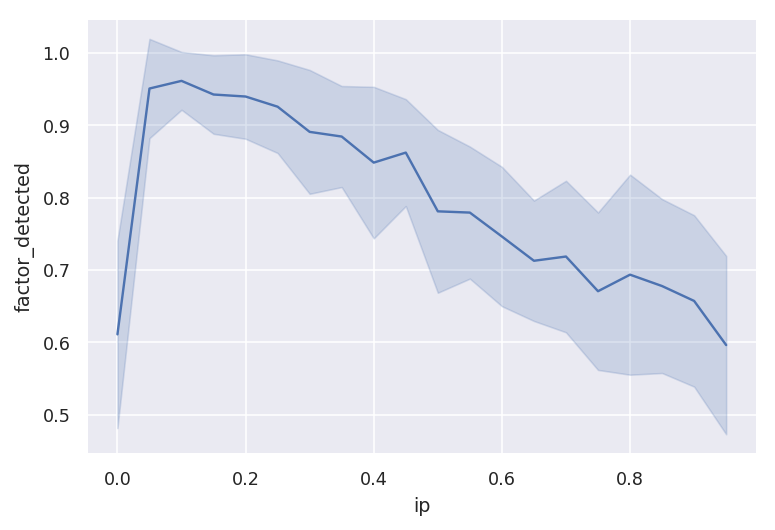

In [694]:
sns.lineplot(x='ip', y='factor_detected', data=exp1_res, ci='sd')

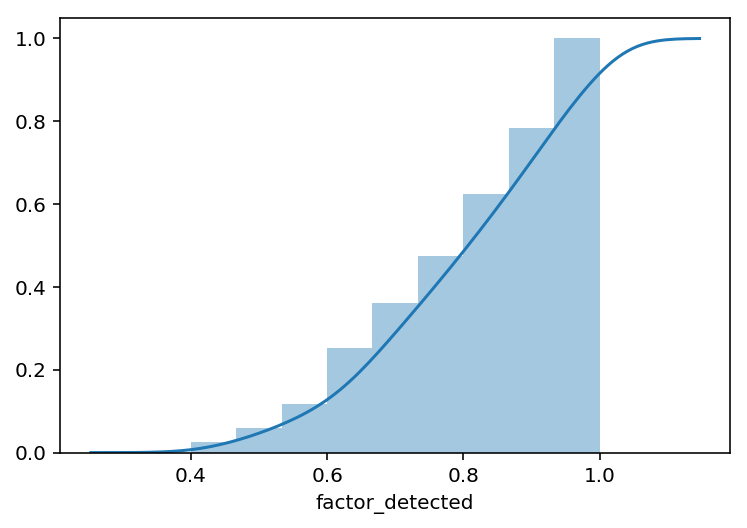

In [172]:
sns.distplot(result.factor_detected, hist_kws={'cumulative': True}, kde_kws={'cumulative': True})

In [ ]:
g = sns.FacetGrid(result, col='ep', col_wrap=5, height=2.5)
g.map(sns.distplot, 'factor_detected', bins=10)

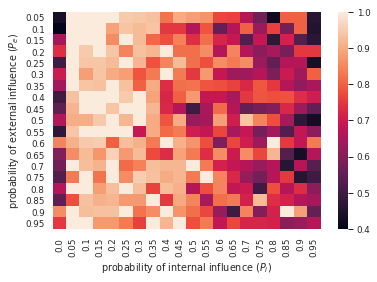

In [178]:
fig, ax = plt.subplots()
sns.heatmap(exp1_res.pivot('ep', 'ip', 'factor_detected'))
ax.set(xlabel='probability of internal influence ($P_i$)', ylabel='probability of external influence ($P_e$)')
fig.savefig("graphics/heatmap.pdf", bbox_inches='tight')

### Simulation for Different $P_e$
10 random nodes will be selected and assigned with different values for $P_e$

In [10]:
class PotHoleOne(soil.agents.FSM):
    
    @soil.agents.default_state
    @soil.agents.state
    def idle(self):
        r = random.random()
        if self['has_ext'] and r < self['prob_tv_spread']:
            self.src = -1
            self.tag = "#Football"
            return self.tweet
        return
    
    @soil.agents.state
    def tweet(self):
        self.state['tag'] = self.tag
        self.state['src'] = self.src
        for neighbor in self.get_neighboring_agents():
            neighbor.tag = self.tag
            neighbor.src = self.id
            neighbor.state['id'] = self.tweet_recv.id
        return self.idle
    
    @soil.agents.state
    def tweet_recv(self):
        prob_infect = self.env['prob_neighbor_spread']
        r = random.random()
        if r < prob_infect:            
            return self.tweet
        return self.idle

#### Code for parallel

In [24]:
%%time
config1 = {
    'name': 'PHOtest',
    'max_time': 2000,
    'interval': 1,
    'num_trials': 1,
    'agent_type': PotHoleOne,
    'default_state': {'has_ext':0, 'prob_tv_spread':0.0},
    'network_params': {
       'path': "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/LDBC_200/network.gexf"
    },    
    'states': 
        {13: {'has_ext': 1,  'prob_tv_spread': 0.9}, 41: {'has_ext': 1,  'prob_tv_spread': 0.8}},
    'environment_params':{        
        'prob_neighbor_spread': 0.5
    }
}

simulations = []

for i in range(6, 10):
    nodes = random.sample(list(net200.nodes()), 10)
    
    dis = {}
    ep = 0.0
    
    for n in nodes:
        ep += 0.1
        dis[int(n)] = {'has_ext': 1, 'prob_tv_spread': float(ep)}

    config1['states'] = dis

    for ip in np.linspace(0,1,20,endpoint=False):
        name = 'PHO_i{0:.3f}_{1}'.format(ip, i)

        config1['name'] = name
        config1['environment_params'] = {'prob_neighbor_spread': float(ip)}       

        simulations.append(config1.copy())

CPU times: user 1 ms, sys: 1 ms, total: 2 ms
Wall time: 2.68 ms


##### testing all simulation configs 

In [ ]:
print(len(simulations))
print(simulations[1])
print(simulations[41])

##### Running simulations in parallel 

In [ ]:
%%time
p = MyPool(8)

#p.map(sim, simulations) #prevention for accidental execution, to run remove the # at the start

p.close()
p.join()

### Analysing results

In [ ]:
def process_simulation_with_ep(df1):
    env = df1[df1.agent_id == 'env'].copy()
    tags = df1[df1.key == 'tag']
    status = df1[df1.key == 'id']
    src = df1[df1.key == 'src']

    dfi = tags.merge(status, on=['agent_id', 't_step'], how='inner')
    dfr = dfi.merge(src, on=['agent_id', 't_step'], how='inner')
    dfr.drop(columns=['key_x', 'key_y', 'key', 'value_type_x', 'value_type_y', 'value_type'], inplace=True)
    dfr.columns = ['user_id', 'ts', 'hashtag', 'status', 'src']
    
    seed_prob = df1[(df1.key == 'prob_tv_spread') & (df1.value != '0.0')]
    seed = df1[(df1.key == 'has_ext') & (df1.value == '1')]
    seed = seed.merge(seed_prob, on='agent_id')[['agent_id', 'value_y']]
    seed.columns = ['agent_id', 'ep']
    return (env, seed, dfr)

def analyse_simulation_with_ep(file, sn):    
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    
    env, seed, cascade = process_simulation_with_ep(df1)
    cascade = cascade.sort_values(by='ts')
    
    daily_stat = split_into_slots(100, 0, 2000, cascade, sn)
    
    ratio = daily_stat.post_kn_count/daily_stat.total_pulses
    ratio = ratio.replace([np.inf, -np.inf], np.nan)
    mr = ratio.mean()
    sr = ratio.std()
    
    print('{2} | mean: {0}; std: {1};'.format(mr, sr, file))
    
    gw_post_count = daily_stat.post_count - daily_stat.post_kn_count
    mg = gw_post_count.mean()
    sg = gw_post_count.std()
    
    print('mean: {0}; std: {1};'.format(mg, sg))
    
    stat_mem = daily_stat.groupby(by='user_id').mean()[['post_count', 'post_kn_count', 'total_pulses']]
    stat_mem.reset_index(inplace=True)
    
    x = stat_mem.apply(membership_mslarge, args=(mr, sr, mg, sg,), axis=1)
    nodes_with_mem = pd.concat([stat_mem, x], axis=1)
    
    return (env, seed, nodes_with_mem)

#### building list of files to be analyzed in parallel

In [55]:
%%time
files = []
for i in range(10):
    for ip in np.linspace(0,1,20,endpoint=False):
        name = 'PHO_i{0:.3f}_{1}'.format(ip, i)
        
        folder = 'soil_output/{0}/'.format(name)
        file = 'soil_output/{0}/{0}_trial_0.environment.csv'.format(name)
        
        files.append((file, folder))

CPU times: user 1 ms, sys: 3 ms, total: 4 ms
Wall time: 4.13 ms


In [59]:
def analysis200_with_ep(file):
    env, seed, mem = analyse_simulation_with_ep(file[0], net200)
    env.to_csv('{0}env.csv'.format(file[1]))
    seed.to_csv('{0}seed.csv'.format(file[1]))
    mem.to_csv('{0}mem.csv'.format(file[1]))
    return

##### Running analysis in parallel 

In [ ]:
p = MyPool(8)

#p.map(analysis200_with_ep, files) #prevention for accidental execution, to run remove the # at the start

p.close()
p.join()

In [90]:
%%time
data = []
ranking = []
for i in range(10):
    for ip in np.linspace(0,1,20,endpoint=False):
        name = 'PHO_i{0:.3f}_{1}'.format(ip, i)
        
        env = pd.read_csv("soil_output/{0}/env.csv".format(name), index_col=0)
        seed = pd.read_csv("soil_output/{0}/seed.csv".format(name), index_col=0)
        mem = pd.read_csv("soil_output/{0}/mem.csv".format(name), index_col=0)

        match_with_true = mem.merge(seed, left_on='user_id', right_on='agent_id', how='inner')
        
        no_seed = len(seed)
        no_detected = len(match_with_true[match_with_true.width > 0])
        factor_detected = no_detected/no_seed

        data.append([i, float(env.iloc[0].value), no_seed, no_detected, factor_detected])
        ranking.append(match_with_true.sort_values(by='ep'))        

CPU times: user 3.27 s, sys: 82 ms, total: 3.35 s
Wall time: 4.1 s


In [92]:
result_v_ep = pd.DataFrame(data, columns=['exp_no','ip', 'no_seed', 'no_detected', 'factor_detected'])
#result_v_ep.to_csv("final_simulation_result_v_ep.csv") #prevention for accidental execution, to run remove the # at the start

In [108]:
result_v_ep = pd.read_csv("final_simulation_result_v_ep.csv", index_col=0)

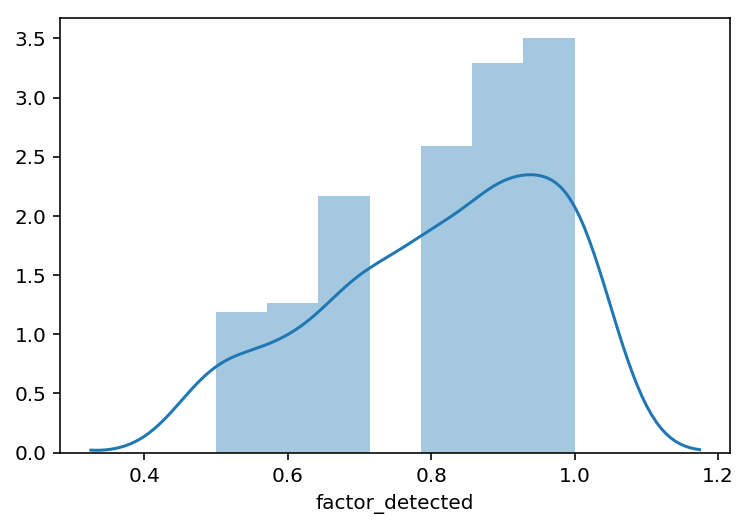

In [89]:
sns.distplot(result_v_ep.factor_detected)

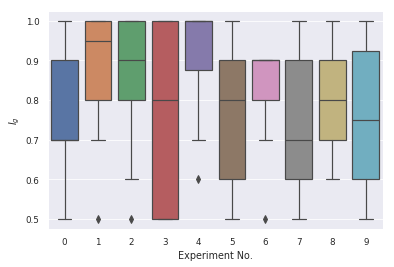

In [177]:
fig, ax = plt.subplots()
sns.boxplot(x='exp_no', y='factor_detected', data=result_v_ep, ax=ax)
ax.set(xlabel='Experiment No.', ylabel='$I_g$')
fig.savefig("graphics/exp_v_ep.pdf", bbox_inches='tight')

### For comparative study

In [52]:
exp1_res = pd.read_csv('final_simulation_result.csv', index_col=0)

In [53]:
exp1_res.head()

ep    ip  no_seed  no_detected  factor_detected
0  0.05  0.00       16            7           0.4375
1  0.05  0.05       23           23           1.0000
2  0.05  0.10       10           10           1.0000
3  0.05  0.15       12           12           1.0000
4  0.05  0.20       12           12           1.0000

In [154]:
deg = sorted(net200.degree(), key=lambda ele: ele[1], reverse=True)
degx = pd.DataFrame([[int(x[0]), int(x[1])] for x in deg], columns=['node', 'degree'])

In [155]:
dd_base = degx.copy()

edg_list = nx.to_pandas_edgelist(net200)
edg_list['target'] = edg_list['target'].apply(pd.to_numeric)
edg_list = edg_list.merge(dd_base, left_on='target', right_on='node')
ndeg = edg_list.groupby(by='source').degree.sum()
ndeg = ndeg.reset_index()
ndeg['source'] = ndeg['source'].apply(pd.to_numeric)
dd_base = dd_base.merge(ndeg, left_on='node', right_on='source')

In [156]:
def degree_discount(d, k, p):
    degdis = d.copy()
    degdis['dd'] = degdis.degree
    degdis['tv'] = 0

    data = set()
    for i in range(k):
        node = degdis.sort_values(by='dd', ascending=False).node.values[i]
        nei = net200.neighbors(str(node))
    
        for n in nei:
            n = int(n)
            if (n in data):
                #print(n)
                continue
            n_row = degdis.index[degdis.node == n]
        
            r = degdis[degdis.node == n]
            tv = r.tv.values[0] + 1
            degdis.at[n_row, 'tv'] = tv
            degdis.at[n_row, 'dd'] = r.degree.values[0] - 2*tv - (r.degree.values[0] - tv)*tv*p
        data.add(node)
    
    return degdis.sort_values(by='dd', ascending=False).head(k)

In [157]:
#list copied from java code output
pmia = [4398046511192,8796093022232,2199023255745,6597069766811,8796093022339,4398046511156,6597069766696,4398046511279,4398046511113,4398046511217,4398046511283,6597069766660,2199023255742,6597069766852,6597069766838,8796093022366,4398046511105,153,2199023255711,4398046511146,4398046511149,6597069766748,4398046511232,6597069766722,2199023255713,6597069766794,85,4398046511194,4398046511220,6597069766687,8796093022357,4398046511133,4398046511285,2199023255572,6597069766786,2199023255629,2199023255716,2199023255740,2199023255612,2199023255574,6597069766775,2199023255672,76,2199023255679,2199023255699,4398046511147,6597069766768,6597069766796,141,2199023255712]
pmia_db = pd.DataFrame(pmia, columns=['node'])

In [56]:
def calculate_compare(row):
    name = 'PH_e{0:.3f}_i{1:.3f}'.format(row.ep, row.ip)
        
    seed = pd.read_csv("soil_output/{0}/seed_1.csv".format(name), index_col=0, dtype={'agent_id':int})
    l = len(seed)
    
    '''Degree'''
    topk = degx.head(l)    
    d = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Diffusion Degree'''
    dd_base['dd_score'] = dd_base.degree_x * row.ip + dd_base.degree_y * row.ip
    topk = dd_base.sort_values(by='dd_score', ascending=False).head(l)
    dd = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Degree Discount'''
    topk = degree_discount(degx, l, row.ip)
    ddis = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''PMIA'''
    topk = pmia_db.head(l)    
    pm = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''NDIF'''
    file = "soil_output/{0}/{0}_trial_0.environment.csv".format(name)
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    env, cascade = process_simulation(df1)
    cascade = cascade.sort_values(by='ts')
    topk = NDIF(InFlowMine(cascade, 100, 20), l)
    ndif = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    return pd.Series([d/l, dd/l, ddis/l, pm/l, ndif/l])


In [63]:
%%time
res = exp1_res.apply(calculate_compare, axis=1)

CPU times: user 29min 3s, sys: 13 s, total: 29min 16s
Wall time: 29min 44s


In [64]:
res2 = pd.concat([exp1_res, res], axis=1)
res2.rename(columns={0:'deg', 1:'dif_deg', 2:'deg_dis', 3:'PMIA', 4:'NDIF'}, inplace=True)

In [65]:
res2.head()

ep    ip  no_seed  no_detected  factor_detected       deg   dif_deg  \
0  0.05  0.00       16            7           0.4375  0.062500  0.062500   
1  0.05  0.05       23           23           1.0000  0.086957  0.130435   
2  0.05  0.10       10           10           1.0000  0.000000  0.000000   
3  0.05  0.15       12           12           1.0000  0.000000  0.000000   
4  0.05  0.20       12           12           1.0000  0.166667  0.000000   

    deg_dis      PMIA      NDIF  
0  0.062500  0.125000  1.000000  
1  0.173913  0.043478  1.000000  
2  0.000000  0.200000  1.000000  
3  0.000000  0.083333  1.000000  
4  0.083333  0.000000  0.333333

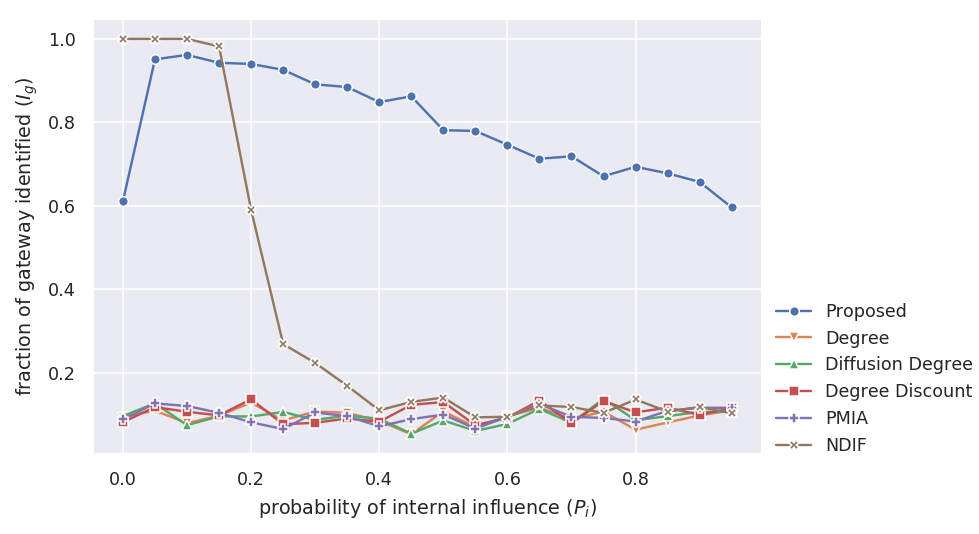

In [681]:
fig, ax = plt.subplots()
#sns.set()
#plt.style.use('default')
sns.set_context("paper")
#sns.scatterplot(x='ip', y='factor_detected', hue='ep', data=res2, ax=ax)
sns.lineplot(x='ip', y='factor_detected', data=res2.groupby(by='ip').mean().reset_index(), ax=ax, marker='o')
sns.lineplot(x='ip', y='deg', data=res2.groupby(by='ip').mean().reset_index(), ax=ax, marker='v')
sns.lineplot(x='ip', y='dif_deg', data=res2.groupby(by='ip').mean().reset_index(), ax=ax, marker='^')
sns.lineplot(x='ip', y='deg_dis', data=res2.groupby(by='ip').mean().reset_index(), ax=ax, marker='s')
sns.lineplot(x='ip', y='PMIA', data=res2.groupby(by='ip').mean().reset_index(), ax=ax, marker='P')
sns.lineplot(x='ip', y='NDIF', data=res2.groupby(by='ip').mean().reset_index(), ax=ax, marker='X')
#sns.lineplot(x='ip', y='factor_detected', data=res2.groupby(by='ip').std().reset_index(), ax=ax)
ax.set(xlabel='probability of internal influence ($P_i$)', ylabel='fraction of gateway identified ($I_g$)')
ldg = fig.legend(loc=3, bbox_to_anchor=(0.88,0.11), frameon=False, ncol=1, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
#ax.legend(loc=3, bbox_to_anchor=(1.0, -0.025), ncol=1)
fig.savefig("graphics/compare_ip.eps", bbox_extra_artists=(ldg,), bbox_inches='tight')

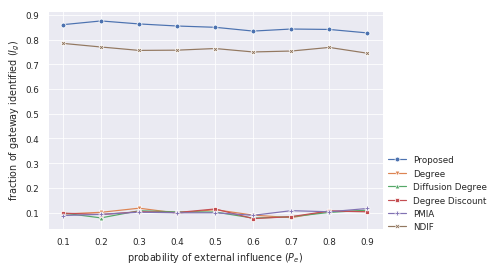

In [176]:
fig, ax = plt.subplots()
sns.lineplot(x='ep', y='factor_detected', data=res2.groupby(by='ep').mean().reset_index(), ax=ax, marker='o')
sns.lineplot(x='ep', y='deg', data=res2.groupby(by='ep').mean().reset_index(), ax=ax, marker='v')
sns.lineplot(x='ep', y='dif_deg', data=res2.groupby(by='ep').mean().reset_index(), ax=ax, marker='^')
sns.lineplot(x='ep', y='deg_dis', data=res2.groupby(by='ep').mean().reset_index(), ax=ax, marker='s')
sns.lineplot(x='ep', y='PMIA', data=res2.groupby(by='ep').mean().reset_index(), ax=ax, marker='P')
sns.lineplot(x='ep', y='NDIF', data=res2.groupby(by='ep').mean().reset_index(), ax=ax, marker='X')
ax.set(xlabel='probability of external influence ($P_e$)', ylabel='fraction of gateway identified ($I_g$)')
ldg = fig.legend(loc=3, bbox_to_anchor=(0.88, 0.11), frameon=False, ncol=1, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
fig.savefig("graphics/compare_ep.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

In [66]:
exp1_proposed = res2[['ep', 'ip', 'factor_detected']].assign(Algo='Proposed')
exp1_degree = res2[['ep', 'ip', 'deg']].assign(Algo='Degree')
exp1_difdeg = res2[['ep', 'ip', 'dif_deg']].assign(Algo='Diffusion Degree')
exp1_degdis = res2[['ep', 'ip', 'deg_dis']].assign(Algo='Degree Discount')
exp1_pmia = res2[['ep', 'ip', 'PMIA']].assign(Algo='PMIA')
exp1_ndif = res2[['ep', 'ip', 'NDIF']].assign(Algo='NDIF')

exp1_degree = exp1_degree.rename(columns={'deg':'factor_detected'})
exp1_difdeg = exp1_difdeg.rename(columns={'dif_deg':'factor_detected'})
exp1_degdis = exp1_degdis.rename(columns={'deg_dis':'factor_detected'})
exp1_pmia = exp1_pmia.rename(columns={'PMIA':'factor_detected'})
exp1_ndif = exp1_ndif.rename(columns={'NDIF':'factor_detected'})

exp1_allres = pd.concat([exp1_proposed, exp1_degree, exp1_difdeg, exp1_degdis, exp1_pmia, exp1_ndif])

In [114]:
exp1_allres = pd.read_csv("exp1_comparative.csv", index_col=0)
#exp1_allres.to_csv("exp1_comparative.csv")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


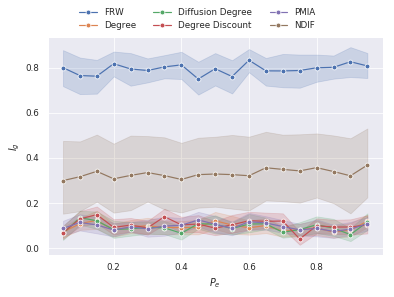

In [175]:
fig, ax = plt.subplots()
sns.lineplot(x='ep', y='factor_detected', hue='Algo', data=exp1_allres, ax=ax, marker='o', legend=False)
ax.set(xlabel='$P_e$', ylabel='$I_g$')
ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['FRW','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
fig.savefig("graphics/compare_ep_range.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


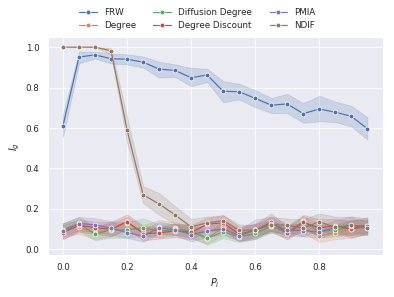

In [174]:
fig, ax = plt.subplots()
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp1_allres, ax=ax, marker='o', legend=False)
ax.set(xlabel='$P_i$', ylabel='$I_g$')
ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['FRW','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
fig.savefig("graphics/compare_ip_range.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

### InFlowMine

NDIF algorithm implementation

In [159]:
def InFlowMine(cascade, f, r):
    freq_tab = cascade.groupby(by='user_id').count()
    freq_tab.reset_index(inplace=True)
    fi1 = freq_tab[freq_tab.hashtag > f]

    fk = {}
    old = set()
    pros = set()
    for n in fi1.user_id.values:
        fk.setdefault(n, set()).add(int(n))
        pros.add(int(n))

    loop = pros.difference(old)
    while(len(loop) > 0):
        pros = set()
        for n in loop:
            old.add(int(n))
            nei = [x for x in net200.neighbors(str(n))]
            tmp = cascade[cascade['user_id'].isin(nei) & (cascade.src == str(n))]
            tmp = tmp.groupby(by='user_id').count()
            f = tmp[tmp.src > r].copy()
            if(len(f)>0):        
                for x in f.index.values:
                    fk.setdefault(str(n), set()).add(int(x))
                    fk.setdefault(x, set()).add(int(x))            
                    pros.add(int(x))
        loop = pros.difference(old)
    return fk


def NDIF(fk, k):
    V = []
    total = set()
    while len(V) < k:
        l = 0
        j = 0
        for x in fk:
            if(x in V):
                continue
            tl = len(total.union(fk[x]))
            if(tl > l):
                l = tl
                j = x

        if j == 0:
            break
        else:
            V.append(int(j))
            total = total.union(fk[j])
    
    return pd.DataFrame(V, columns=['node'])

In [102]:
def calculate_compare_v_ep(row):
    name = 'PHO_i{0:.3f}_{1}'.format(row.ip, int(row.exp_no))
        
    seed = pd.read_csv("soil_output/{0}/seed.csv".format(name), index_col=0, dtype={'agent_id':int})
    l = len(seed)
    
    '''Degree'''
    topk = degx.head(l)    
    d = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Diffusion Degree'''
    dd_base['dd_score'] = dd_base.degree_x * row.ip + dd_base.degree_y * row.ip
    topk = dd_base.sort_values(by='dd_score', ascending=False).head(l)
    dd = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Degree Discount'''
    topk = degree_discount(degx, l, row.ip)
    ddis = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''PMIA'''
    topk = pmia_db.head(l)    
    pm = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''NDIF'''
    file = "soil_output/{0}/{0}_trial_0.environment.csv".format(name)
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    env, cascade = process_simulation(df1)
    cascade = cascade.sort_values(by='ts')
    topk = NDIF(InFlowMine(cascade, 100, 20), l)
    ndif = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    return pd.Series([d/l, dd/l, ddis/l, pm/l, ndif/l])

In [103]:
%%time
res = result_v_ep.apply(calculate_compare_v_ep, axis=1)

CPU times: user 15min 26s, sys: 22.6 s, total: 15min 48s
Wall time: 15min 25s


In [104]:
exp2_res2 = pd.concat([result_v_ep, res], axis=1)
exp2_res2.rename(columns={0:'deg', 1:'dif_deg', 2:'deg_dis', 3:'PMIA', 4:'NDIF'}, inplace=True)

In [105]:
proposed = exp2_res2[['exp_no', 'ip', 'factor_detected']].assign(Algo='Proposed')
degree = exp2_res2[['exp_no', 'ip', 'deg']].assign(Algo='Degree')
difdeg = exp2_res2[['exp_no', 'ip', 'dif_deg']].assign(Algo='Diffusion Degree')
degdis = exp2_res2[['exp_no', 'ip', 'deg_dis']].assign(Algo='Degree Discount')
pmia = exp2_res2[['exp_no', 'ip', 'PMIA']].assign(Algo='PMIA')
ndif = exp2_res2[['exp_no', 'ip', 'NDIF']].assign(Algo='NDIF')

degree = degree.rename(columns={'deg':'factor_detected'})
difdeg = difdeg.rename(columns={'dif_deg':'factor_detected'})
degdis = degdis.rename(columns={'deg_dis':'factor_detected'})
pmia = pmia.rename(columns={'PMIA':'factor_detected'})
ndif = ndif.rename(columns={'NDIF':'factor_detected'})

allres = pd.concat([proposed, degree, difdeg, degdis, pmia, ndif])

In [109]:
sns.set()
sns.set_context("paper")

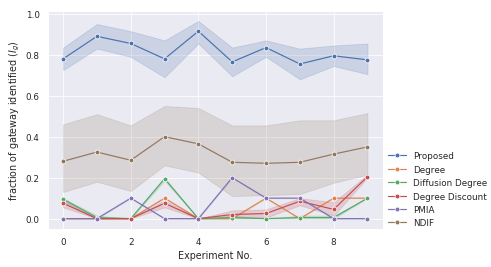

In [111]:
fig, ax = plt.subplots()
sns.lineplot(x='exp_no', y='factor_detected', hue='Algo', data=allres, ax=ax, marker='o', legend=False)
ldg = fig.legend(loc=3, bbox_to_anchor=(0.88, 0.11), frameon=False, ncol=1, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax.set(xlabel='Experiment No.', ylabel='fraction of gateway identified ($I_g$)');
#fig.savefig("graphics/compare_v_ep.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

### Simulation for Variable $P_i$

In [4]:
class PotHoleTwo(soil.agents.FSM):
    
    @soil.agents.default_state
    @soil.agents.state
    def idle(self):
        r = random.random()
        if self['has_ext'] and r < self.env['prob_tv_spread']:
            self.src = -1
            self.tag = "#Football"
            return self.tweet
        return
    
    @soil.agents.state
    def tweet(self):
        self.state['tag'] = self.tag
        self.state['src'] = self.src
        for neighbor in self.get_neighboring_agents():
            neighbor.tag = self.tag
            neighbor.src = self.id
            neighbor.state['id'] = self.tweet_recv.id
        return self.idle
    
    @soil.agents.state
    def tweet_recv(self):
        prob_infect = self['prob_neighbor_spread']
        r = random.random()
        if r < prob_infect:            
            return self.tweet
        return self.idle

In [19]:
config1 = {
    'name': 'PH5',
    'max_time': 2000,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'path': "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/LDBC_200/network.gexf"
    },
    'network_agents': [
        {
            'agent_type': PotHoleTwo,
            'weight': 9,
            'state': { 'has_ext': 0 }
        },        
        {
            'agent_type': PotHoleTwo,
            'weight': 1,
            'state': {'has_ext' : 1 }
        }
    ],
    'states': {13: {'prob_neighbor_spread': 0.5}, 41: {'prob_neighbor_spread': 0.1}},
    'environment_params':{
        'prob_tv_spread': 0.5
    }
}

simulations = []

for i in range(0, 10):
    dis = {}
    
    for n in net200.nodes():
        dis[int(n)] = {'prob_neighbor_spread': float(random.random())}

    config1['states'] = dis

    for ep in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'PHV_e{0:.3f}_{1}'.format(ep, i)

        config1['name'] = name
        config1['environment_params'] = {'prob_tv_spread': float(ep)}       

        simulations.append(config1.copy())

In [ ]:
%%time
p = MyPool(8)

p.map(sim, simulations)

p.close()
p.join()

### Analyze for variable $P_i$

In [31]:
df1 = pd.read_csv("soil_output/PHV_e0.400_0/PHV_e0.400_0_trial_0.environment.csv", dtype={'agent_id': str})
df1.head()

agent_id  t_step                   key              value  value_type
0            env       0        prob_tv_spread                0.4         NaN
1  4398046511192       0  prob_neighbor_spread  0.365170459034626         NaN
2  4398046511192       0               has_ext                  0         NaN
3  4398046511192       0                    id               idle         NaN
4  8796093022232       0  prob_neighbor_spread  0.686333614615782         NaN

In [38]:
i_prob = df1[(df1.key == 'prob_neighbor_spread')].copy()
i_prob.drop(columns=['t_step', 'key', 'value_type'], inplace=True)
i_prob.columns = ['agent_id', 'ip']

In [39]:
i_prob.head()

agent_id                 ip
1   4398046511192  0.365170459034626
4   8796093022232  0.686333614615782
7   4398046511194  0.447726732375377
10  4398046511217  0.519685440046681
13  4398046511283  0.735290626531508

In [41]:
def process_simulation_with_ip(df1):
    env = df1[df1.agent_id == 'env'].copy()
    tags = df1[df1.key == 'tag']
    status = df1[df1.key == 'id']
    src = df1[df1.key == 'src']

    dfi = tags.merge(status, on=['agent_id', 't_step'], how='inner')
    dfr = dfi.merge(src, on=['agent_id', 't_step'], how='inner')
    dfr.drop(columns=['key_x', 'key_y', 'key', 'value_type_x', 'value_type_y', 'value_type'], inplace=True)
    dfr.columns = ['user_id', 'ts', 'hashtag', 'status', 'src']
    
    i_prob = df1[(df1.key == 'prob_neighbor_spread')].copy()
    i_prob.drop(columns=['t_step', 'key', 'value_type'], inplace=True)
    i_prob.columns = ['agent_id', 'ip']   
    
    seed = df1[(df1.key == 'has_ext') & (df1.value == '1')]    
    return (env, seed, i_prob, dfr)

def analyse_simulation_with_ip(file, sn):    
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    
    env, seed, ips, cascade = process_simulation_with_ip(df1)
    cascade = cascade.sort_values(by='ts')
    
    daily_stat = split_into_slots(100, 0, 2000, cascade, sn)
    
    ratio = daily_stat.post_kn_count/daily_stat.total_pulses
    ratio = ratio.replace([np.inf, -np.inf], np.nan)
    mr = ratio.mean()
    sr = ratio.std()
    
    print('{2} | mean: {0}; std: {1};'.format(mr, sr, file))
    
    gw_post_count = daily_stat.post_count - daily_stat.post_kn_count
    mg = gw_post_count.mean()
    sg = gw_post_count.std()
    
    print('mean: {0}; std: {1};'.format(mg, sg))
    
    stat_mem = daily_stat.groupby(by='user_id').mean()[['post_count', 'post_kn_count', 'total_pulses']]
    stat_mem.reset_index(inplace=True)
    
    x = stat_mem.apply(membership_mslarge, args=(mr, sr, mg, sg,), axis=1)
    nodes_with_mem = pd.concat([stat_mem, x], axis=1)
    
    return (env, seed, ips, nodes_with_mem)

#### building list of files to be analyzed in parallel

In [42]:
%%time
files = []
for i in range(10):
    for ep in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'PHV_e{0:.3f}_{1}'.format(ep, i)        
        
        folder = 'soil_output/{0}/'.format(name)
        file = 'soil_output/{0}/{0}_trial_0.environment.csv'.format(name)
        
        files.append((file, folder))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.6 ms


In [44]:
len(files)

190

In [47]:
def analysis200_with_ip(file):
    env, seed, ip, mem = analyse_simulation_with_ip(file[0], net200)
    env.to_csv('{0}env.csv'.format(file[1]))
    seed.to_csv('{0}seed.csv'.format(file[1]))
    mem.to_csv('{0}mem.csv'.format(file[1]))
    ip.to_csv('{0}ip_val.csv'.format(file[1]))
    return

##### Running analysis in parallel 

In [ ]:
p = MyPool(8)

p.map(analysis200_with_ip, files)

p.close()
p.join()

In [52]:
%%time
data = []
for i in range(10):
    for ep in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'PHV_e{0:.3f}_{1}'.format(ep, i)
        
        env = pd.read_csv("soil_output/{0}/env.csv".format(name), index_col=0)
        seed = pd.read_csv("soil_output/{0}/seed.csv".format(name), index_col=0)
        mem = pd.read_csv("soil_output/{0}/mem.csv".format(name), index_col=0)
        ip = pd.read_csv("soil_output/{0}/ip_val.csv".format(name), index_col=0)

        match_with_true = mem.merge(seed, left_on='user_id', right_on='agent_id', how='inner')
        
        no_seed = len(seed)
        no_detected = len(match_with_true[match_with_true.width > 0])
        factor_detected = no_detected/no_seed

        data.append([i, float(env.iloc[0].value), no_seed, no_detected, factor_detected])        

CPU times: user 8.96 s, sys: 30 ms, total: 8.99 s
Wall time: 10.1 s


In [53]:
result_v_ip = pd.DataFrame(data, columns=['exp_no','ep', 'no_seed', 'no_detected', 'factor_detected'])
#result_v_ip.to_csv("final_simulation_result_v_ip.csv")

In [112]:
result_v_ip = pd.read_csv("final_simulation_result_v_ip.csv", index_col=0)

In [96]:
result_v_ip.head()

exp_no    ep  no_seed  no_detected  factor_detected
0       0  0.05       16            9         0.562500
1       0  0.10       13            9         0.692308
2       0  0.15       16           10         0.625000
3       0  0.20       17           10         0.588235
4       0  0.25       15           10         0.666667

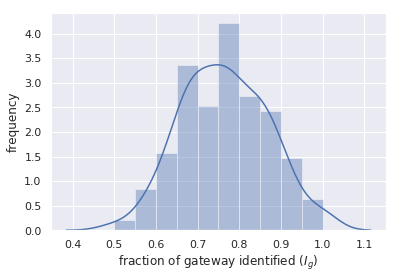

In [88]:
fig, ax = plt.subplots()
sns.distplot(result_v_ip.factor_detected)

ax.set(xlabel='fraction of gateway identified ($I_g$)', ylabel='frequency')
fig.savefig("graphics/dist_v_ip.pdf", bbox_inches='tight')

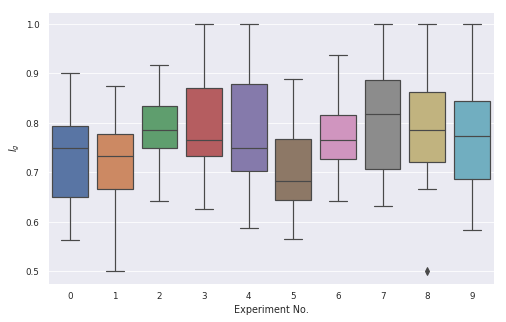

In [171]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x='exp_no', y='factor_detected', data=result_v_ip, ax=ax)
ax.set(xlabel='Experiment No.', ylabel='$I_g$')
fig.savefig("graphics/exp_v_ip.pdf", bbox_inches='tight')

### Variable $P_i$ comparative study

In [74]:
dd_base['dd_score'] = 0.0

In [79]:
def calculate_compare_v_ip(row):
    name = 'PHV_e{0:.3f}_{1}'.format(row.ep, int(row.exp_no))
        
    seed = pd.read_csv("soil_output/{0}/seed.csv".format(name), index_col=0, dtype={'agent_id':int})
    l = len(seed)
    
    ips = pd.read_csv("soil_output/{0}/ip_val.csv".format(name), index_col=0, dtype={'agent_id':int})
    print(ips.ip.mean())
    
    '''Degree'''
    topk = degx.head(l)    
    d = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Diffusion Degree'''
    dd_base['dd_score'] = dd_base.degree_x * ips + dd_base.degree_y * ips    
    topk = dd_base.sort_values(by='dd_score', ascending=False).head(l)
    dd = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Degree Discount'''
    topk = degree_discount(degx, l, ips)
    ddis = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''PMIA'''
    topk = pmia_db.head(l)    
    pm = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''NDIF'''
    file = "soil_output/{0}/{0}_trial_0.environment.csv".format(name)
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    env, s, ip_val, cascade = process_simulation_with_ip(df1)
    cascade = cascade.sort_values(by='ts')
    topk = NDIF(InFlowMine(cascade, 100, 20), l)
    ndif = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    return pd.Series([d/l, dd/l, ddis/l, pm/l, ndif/l])

In [ ]:
%%time
res = result_v_ip.apply(calculate_compare_v_ip, axis=1)

In [82]:
exp3_res2 = pd.concat([result_v_ip, res], axis=1)
exp3_res2.rename(columns={0:'deg', 1:'dif_deg', 2:'deg_dis', 3:'PMIA', 4:'NDIF'}, inplace=True)

In [83]:
proposed = exp3_res2[['exp_no', 'ep', 'factor_detected']].assign(Algo='Proposed')
degree = exp3_res2[['exp_no', 'ep', 'deg']].assign(Algo='Degree')
difdeg = exp3_res2[['exp_no', 'ep', 'dif_deg']].assign(Algo='Diffusion Degree')
degdis = exp3_res2[['exp_no', 'ep', 'deg_dis']].assign(Algo='Degree Discount')
pmia = exp3_res2[['exp_no', 'ep', 'PMIA']].assign(Algo='PMIA')
ndif = exp3_res2[['exp_no', 'ep', 'NDIF']].assign(Algo='NDIF')

degree = degree.rename(columns={'deg':'factor_detected'})
difdeg = difdeg.rename(columns={'dif_deg':'factor_detected'})
degdis = degdis.rename(columns={'deg_dis':'factor_detected'})
pmia = pmia.rename(columns={'PMIA':'factor_detected'})
ndif = ndif.rename(columns={'NDIF':'factor_detected'})

exp3_allres = pd.concat([proposed, degree, difdeg, degdis, pmia, ndif])

In [85]:
sns.set()

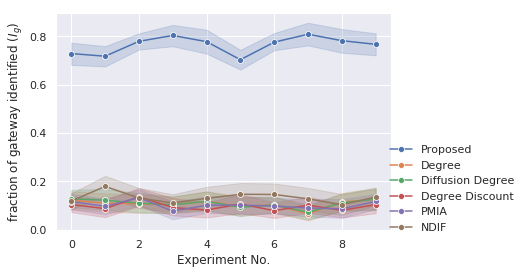

In [86]:
fig, ax = plt.subplots()
sns.lineplot(x='exp_no', y='factor_detected', hue='Algo', data=exp3_allres, ax=ax, marker='o', legend=False)
ldg = fig.legend(loc=3, bbox_to_anchor=(0.88, 0.11), frameon=False, ncol=1, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax.set(xlabel='Experiment No.', ylabel='fraction of gateway identified ($I_g$)')
fig.savefig("graphics/compare_v_ip.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

In [89]:
exp3_res2.factor_detected.mean()

0.76471576552067466

In [96]:
result_v_ip.groupby(by='exp_no').median()

ep  no_seed  no_detected  factor_detected
exp_no                                            
0       0.5       15           10         0.750000
1       0.5       16           12         0.733333
2       0.5       14           11         0.785714
3       0.5       14           12         0.764706
4       0.5       14           10         0.750000
5       0.5       14           10         0.681818
6       0.5       16           12         0.764706
7       0.5       14           11         0.818182
8       0.5       14           11         0.785714
9       0.5       15           13         0.772727

In [116]:
result_v_ep.head()

exp_no    ip  no_seed  no_detected  factor_detected
0       0  0.00       10            5              0.5
1       0  0.05       10            9              0.9
2       0  0.10       10           10              1.0
3       0  0.15       10           10              1.0
4       0  0.20       10            9              0.9

### Cascade Size

Varing cascade size from 0 to 4 and simulate it for sensitivity analysis!!

In [4]:
class PotHoleThree(soil.agents.FSM):
    
    @soil.agents.default_state
    @soil.agents.state
    def idle(self):
        r = random.random()
        if self['has_ext'] and r < self.env['prob_tv_spread']:
            self.src = -1
            self.tag = "#Football"
            self.cascade = 0
            return self.tweet
        return
    
    @soil.agents.state
    def tweet(self):
        self.state['tag'] = self.tag
        self.state['src'] = self.src
        if self.cascade < self.env['max_cascade_size']:
            for neighbor in self.get_neighboring_agents():
                neighbor.tag = self.tag
                neighbor.cascade = self.cascade + 1
                neighbor.src = self.id
                neighbor.state['id'] = self.tweet_recv.id
        return self.idle
    
    @soil.agents.state
    def tweet_recv(self):
        prob_infect = self.env['prob_neighbor_spread']
        r = random.random()
        if r < prob_infect:            
            return self.tweet
        return self.idle

In [5]:
config1 = {
    'name': 'PH5',
    'max_time': 2000,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'path': "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/LDBC_200/network.gexf"
    },
    'network_agents': [
        {
            'agent_type': PotHoleThree,
            'weight': 9,
            'state': { 'has_ext': 0 }
        },        
        {
            'agent_type': PotHoleThree,
            'weight': 1,
            'state': {'has_ext' : 1 }
        }
    ],    
    'environment_params':{
        'prob_tv_spread': 0.5,
        'prob_neighbor_spread': 0.5,
        'max_cascade_size': 1
    }
}

simulations = []
for ep in np.linspace(0,1,10,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,0.55,11,endpoint=False):
        if(ep == 0.0):
            continue
        for cs in range(0, 5):
            name = 'PHC_e{0:.3f}_i{1:.3f}_c{2}'.format(ep, ip, cs)
            
            #file = 'soil_output/PHC/{0}/{0}_trial_0.environment.csv'.format(name)
            
            #if(os.path.exists(file)):
            #    continue
    
            config1['name'] = name
            config1['environment_params'] = {'prob_tv_spread': float(ep), 
                                         'prob_neighbor_spread': float(ip),
                                         'max_cascade_size': int(cs)}       
            simulations.append(config1.copy())

In [6]:
len(simulations)

132

In [ ]:
p = MyPool(8, maxtasksperchild=8)

#p.map(sim, simulations[70:])

p.close()
p.join()

In [26]:
def process_simulation_with_cs(df1):
    env = df1[df1.agent_id == 'env'].copy()
    tags = df1[df1.key == 'tag']
    status = df1[df1.key == 'id']
    src = df1[df1.key == 'src']

    dfi = tags.merge(status, on=['agent_id', 't_step'], how='inner')
    dfr = dfi.merge(src, on=['agent_id', 't_step'], how='inner')
    dfr.drop(columns=['key_x', 'key_y', 'key', 'value_type_x', 'value_type_y', 'value_type'], inplace=True)
    dfr.columns = ['user_id', 'ts', 'hashtag', 'status', 'src']
    
    seed = df1[(df1.key == 'has_ext') & (df1.value == '1')]    
    return (env, seed, dfr)

def analyse_simulation_with_cs(file, sn):    
    df1 = pd.read_csv(file, dtype={'agent_id': str})
    
    env, seed, cascade = process_simulation_with_cs(df1)
    cascade = cascade.sort_values(by='ts')
    
    daily_stat = split_into_slots(100, 0, 2000, cascade, sn)
    
    ratio = daily_stat.post_kn_count/daily_stat.total_pulses
    ratio = ratio.replace([np.inf, -np.inf], np.nan)
    mr = ratio.mean()
    sr = ratio.std()
    
    print('{2} | mean: {0}; std: {1};'.format(mr, sr, file))
    
    gw_post_count = daily_stat.post_count - daily_stat.post_kn_count
    mg = gw_post_count.mean()
    sg = gw_post_count.std()
    
    print('mean: {0}; std: {1};'.format(mg, sg))
    
    stat_mem = daily_stat.groupby(by='user_id').mean()[['post_count', 'post_kn_count', 'total_pulses']]
    stat_mem.reset_index(inplace=True)
    
    x = stat_mem.apply(membership_mslarge, args=(mr, sr, mg, sg,), axis=1)
    nodes_with_mem = pd.concat([stat_mem, x], axis=1)
    
    return (env, seed, nodes_with_mem, cascade)

In [21]:
%%time
files = []
for ep in np.linspace(0,1,10,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,0.55,11,endpoint=False):
        if(ep == 0.0):
            continue
        for cs in range(0, 5):
            name = 'PHC_e{0:.3f}_i{1:.3f}_c{2}'.format(ep, ip, cs)      
        
            folder = 'soil_output/PHC/{0}/'.format(name)
            file = 'soil_output/PHC/{0}/{0}_trial_0.environment.csv'.format(name)
        
            files.append((file, folder))

CPU times: user 9 ms, sys: 0 ns, total: 9 ms
Wall time: 8.48 ms


In [15]:
files[1]

('soil_output/PHC/PHC_e0.100_i0.000_c1/PHC_e0.100_i0.000_c1_trial_0.environment.csv',
 'soil_output/PHC_e0.100_i0.000_c1/')

In [24]:
def analysis_with_cs(file):
    env, seed, mem, cas = analyse_simulation_with_cs(file[0], net200)
    env.to_csv('{0}env.csv'.format(file[1]))
    seed.to_csv('{0}seed.csv'.format(file[1]))
    mem.to_csv('{0}mem.csv'.format(file[1]))
    cas.to_csv('{0}cascade.csv'.format(file[1]))
    return

In [28]:
analysis_with_cs(files[50])
analysis_with_cs(files[54])

soil_output/PHC/PHC_e0.100_i0.500_c0/PHC_e0.100_i0.500_c0_trial_0.environment.csv | mean: 0.0; std: 0.0;
mean: 9.126470588235295; std: 2.55416933988949;
soil_output/PHC/PHC_e0.100_i0.500_c4/PHC_e0.100_i0.500_c4_trial_0.environment.csv | mean: 0.14458649204499627; std: 0.08694759304871477;
mean: 0.4586904353788139; std: 1.7310875168227544;


In [ ]:
p = MyPool(8, maxtasksperchild=8)

#p.map(analysis_with_cs, files[100:])

p.close()
p.join()

In [33]:
%%time
data = []
for ep in np.linspace(0,1,10,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,0.55,11,endpoint=False):
        if(ep == 0.0):
            continue
        for cs in range(0, 5):
            name = 'PHC_e{0:.3f}_i{1:.3f}_c{2}'.format(ep, ip, cs)

            env = pd.read_csv("soil_output/PHC/{0}/env.csv".format(name), index_col=0)
            seed = pd.read_csv("soil_output/PHC/{0}/seed.csv".format(name), index_col=0)
            mem = pd.read_csv("soil_output/PHC/{0}/mem.csv".format(name), index_col=0)

            match_with_true = mem.merge(seed, left_on='user_id', right_on='agent_id', how='inner')

            no_seed = len(seed)
            no_detected = len(match_with_true[match_with_true.width > 0])
            factor_detected = no_detected/no_seed

            data.append([ep, ip, cs, no_seed, no_detected, factor_detected])

In [34]:
result_w_cs = pd.DataFrame(data, columns=['ep', 'ip', 'cs', 'no_seed', 'no_detected', 'factor_detected'])

In [42]:
#result_w_cs.to_csv("soil_output/PHC/final_result_cs.csv")

In [76]:
result_w_cs = pd.read_csv("soil_output/PHC/final_result_cs.csv", index_col=0)

In [150]:
result_w_cs.head()

ep   ip  cs  no_seed  no_detected  factor_detected
0  0.1  0.0   0       17            9         0.529412
1  0.1  0.0   1       11            6         0.545455
2  0.1  0.0   2       18           10         0.555556
3  0.1  0.0   3       10            5         0.500000
4  0.1  0.0   4       17           10         0.588235

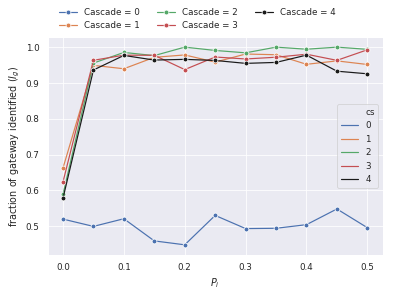

In [96]:
fig, ax = plt.subplots()

sns.lineplot(x='ip', y='factor_detected', hue='cs',  palette=["C0", "C1","C2", "C3", "k"], data=result_w_cs, ax=ax, ci=None, marker='o')
ldg = fig.legend(loc=9, ncol=3, frameon=False, labels=['Cascade = 0','Cascade = 1','Cascade = 2','Cascade = 3','Cascade = 4'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax.set(xlabel='$P_i$', ylabel='fraction of gateway identified ($I_g$)')
fig.savefig("graphics/cascade_ip.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

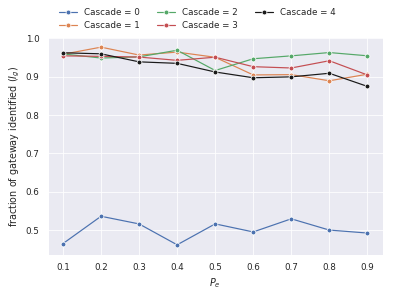

In [95]:
fig, ax = plt.subplots()

sns.lineplot(x='ep', y='factor_detected', hue='cs',  palette=["C0", "C1","C2", "C3", "k"], data=result_w_cs, ax=ax, ci=None, marker='o', legend=False)
ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Cascade = 0','Cascade = 1','Cascade = 2','Cascade = 3','Cascade = 4'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax.set(xlabel='$P_e$', ylabel='fraction of gateway identified ($I_g$)')
fig.savefig("graphics/cascade_ep.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

In [149]:
def calculate_compare_cs(row):
    name = 'PHC_e{0:.3f}_i{1:.3f}_c{2}'.format(row.ep, row.ip, int(row.cs))
        
    seed = pd.read_csv("soil_output/PHC/{0}/seed.csv".format(name), index_col=0, dtype={'agent_id':int})
    l = len(seed)
    
    '''Degree'''
    topk = degx.head(l)    
    d = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Diffusion Degree'''
    dd_base['dd_score'] = dd_base.degree_x * row.ip + dd_base.degree_y * row.ip
    topk = dd_base.sort_values(by='dd_score', ascending=False).head(l)
    dd = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''Degree Discount'''
    topk = degree_discount(degx, l, row.ip)
    ddis = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''PMIA'''
    topk = pmia_db.head(l)    
    pm = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    '''NDIF'''
    file = "soil_output/PHC/{0}/cascade.csv".format(name)
    cascade = pd.read_csv(file, dtype={'user_id': str, 'ts':int, 'src': str}, index_col=0)    
    topk = NDIF(InFlowMine(cascade, 100, 20), l)
    ndif = len(seed.merge(topk, left_on='agent_id', right_on='node', how='inner'))
    
    return pd.Series([d/l, dd/l, ddis/l, pm/l, ndif/l])


In [160]:
%%time
res = result_w_cs.apply(calculate_compare_cs, axis=1)

CPU times: user 30min 5s, sys: 0 ns, total: 30min 5s
Wall time: 30min 30s


In [161]:
res2 = pd.concat([result_w_cs, res], axis=1)
res2.rename(columns={0:'deg', 1:'dif_deg', 2:'deg_dis', 3:'PMIA', 4:'NDIF'}, inplace=True)

In [162]:
res2.head()

ep   ip  cs  no_seed  no_detected  factor_detected       deg   dif_deg  \
0  0.1  0.0   0       17            9         0.529412  0.117647  0.235294   
1  0.1  0.0   1       11            6         0.545455  0.000000  0.000000   
2  0.1  0.0   2       18           10         0.555556  0.111111  0.055556   
3  0.1  0.0   3       10            5         0.500000  0.200000  0.000000   
4  0.1  0.0   4       17           10         0.588235  0.058824  0.117647   

    deg_dis      PMIA  NDIF  
0  0.176471  0.294118   1.0  
1  0.000000  0.181818   1.0  
2  0.111111  0.166667   1.0  
3  0.100000  0.000000   1.0  
4  0.058824  0.117647   1.0

In [163]:
proposed = res2[['ip', 'ep', 'cs', 'factor_detected']].assign(Algo='Proposed')
degree = res2[['ip', 'ep', 'cs', 'deg']].assign(Algo='Degree')
difdeg = res2[['ip', 'ep', 'cs', 'dif_deg']].assign(Algo='Diffusion Degree')
degdis = res2[['ip', 'ep', 'cs', 'deg_dis']].assign(Algo='Degree Discount')
pmia = res2[['ip', 'ep', 'cs', 'PMIA']].assign(Algo='PMIA')
ndif = res2[['ip', 'ep', 'cs', 'NDIF']].assign(Algo='NDIF')

degree = degree.rename(columns={'deg':'factor_detected'})
difdeg = difdeg.rename(columns={'dif_deg':'factor_detected'})
degdis = degdis.rename(columns={'deg_dis':'factor_detected'})
pmia = pmia.rename(columns={'PMIA':'factor_detected'})
ndif = ndif.rename(columns={'NDIF':'factor_detected'})

exp4_allres = pd.concat([proposed, degree, difdeg, degdis, pmia, ndif])

In [164]:
exp4_allres.to_csv('datasets/twitter_2013/exp4_allres.csv')

In [85]:
sns.set()

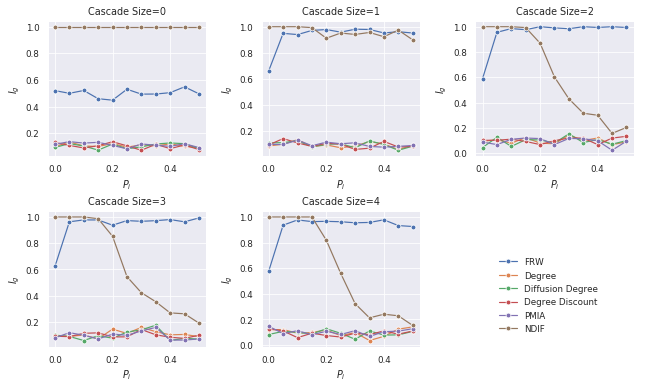

In [167]:
fig, ax = plt.subplots(2, 3, figsize=(10.5,6))

sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp4_allres[exp4_allres.cs == 0], ax=ax[0,0], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp4_allres[exp4_allres.cs == 1], ax=ax[0,1], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp4_allres[exp4_allres.cs == 2], ax=ax[0,2], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp4_allres[exp4_allres.cs == 3], ax=ax[1,0], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp4_allres[exp4_allres.cs == 4], ax=ax[1,1], marker='o', legend=False, ci=None)
ldg = fig.legend(loc=3, bbox_to_anchor=(0.65, 0.11), frameon=False, ncol=1, labels=['FRW','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax[0][0].set(xlabel='$P_i$', ylabel='$I_g$')
ax[1][0].set(xlabel='$P_i$', ylabel='$I_g$')
ax[0][1].set(xlabel='$P_i$', ylabel='$I_g$')
ax[1][1].set(xlabel='$P_i$', ylabel='$I_g$')
ax[0][2].set(xlabel='$P_i$', ylabel='$I_g$')

ax[0][0].set_title('Cascade Size=0')
ax[0][1].set_title('Cascade Size=1')
ax[0][2].set_title('Cascade Size=2')
ax[1][0].set_title('Cascade Size=3')
ax[1][1].set_title('Cascade Size=4')
#ax.set(xlabel='$I_p$', ylabel='fraction of gateway identified ($I_g$)')
#fig.savefig("graphics/compare_v_ip.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')
fig.delaxes(ax[1][2])
plt.subplots_adjust(hspace=.4, wspace=.35)
fig.savefig("graphics/compare_cascade.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

In [103]:
def membership_mslarge_with_a(row, mg, sg):
    gw_post = row.post_count - row.post_kn_count 
    
    gateway1 = ms_large(gw_post, 0.8, 3, mg, sg)
    gateway2 = ms_large(gw_post, 0.6, 3, mg, sg)
    gateway3 = ms_large(gw_post, 0.4, 3, mg, sg)
    gateway4 = ms_large(gw_post, 0.2, 3, mg, sg)
    gateway5 = ms_large(gw_post, 0.0, 3, mg, sg)
    
    return pd.Series({'width08': gateway1, 'width06': gateway2, 'width04': gateway3, 'width02': gateway4, 'width00': gateway5})

def analyse_simulation_for_dif_a(files, sn):    
    cascade = pd.read_csv(files[0], dtype={'user_id': str, 'ts':int, 'src': str}, index_col=0)
    
    daily_stat = split_into_slots(100, 0, 2000, cascade, sn) 
    
    gw_post_count = daily_stat.post_count - daily_stat.post_kn_count
    mg = gw_post_count.mean()
    sg = gw_post_count.std()
    
    print('mean: {0}; std: {1};'.format(mg, sg))
    
    stat_mem = pd.read_csv(files[1], index_col=0)
        
    x = stat_mem.apply(membership_mslarge_with_a, args=(mg, sg,), axis=1)
    nodes_with_mem = pd.concat([stat_mem, x], axis=1)
    
    return nodes_with_mem

In [93]:
%%time
files = []
for ep in np.linspace(0,1,10,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,0.55,11,endpoint=False):
        if(ep == 0.0):
            continue
        for cs in range(0, 5):
            name = 'PHC_e{0:.3f}_i{1:.3f}_c{2}'.format(ep, ip, cs)      
        
            folder = 'soil_output/PHC/{0}/'.format(name) 
            file1 = 'soil_output/PHC/{0}/cascade.csv'.format(name)
            file2 = 'soil_output/PHC/{0}/mem.csv'.format(name)
        
            files.append((file1, file2, folder))

CPU times: user 9 ms, sys: 0 ns, total: 9 ms
Wall time: 8.89 ms


In [94]:
files[1]

('soil_output/PHC/PHC_e0.100_i0.000_c1/cascade.csv',
 'soil_output/PHC/PHC_e0.100_i0.000_c1/mem.csv',
 'soil_output/PHC/PHC_e0.100_i0.000_c1/')

In [98]:
def analysis_with_cs_a(file):
    mem = analyse_simulation_for_dif_a(file, net200)    
    mem.to_csv('{0}mem_all.csv'.format(file[2]))    
    return

In [104]:
analysis_with_cs_a(files[1])

mean: 8.840909090909092; std: 2.6530174241578237;


In [105]:
len(files)

495

In [ ]:
p = MyPool(8, maxtasksperchild=8)

#p.map(analysis_with_cs_a, files[100:])

p.close()
p.join()

In [124]:
%%time
data = []
for ep in np.linspace(0,1,10,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,0.55,11,endpoint=False):
        if(ep == 0.0):
            continue
        for cs in range(0, 5):
            name = 'PHC_e{0:.3f}_i{1:.3f}_c{2}'.format(ep, ip, cs)

            seed = pd.read_csv("soil_output/PHC/{0}/seed.csv".format(name), index_col=0)
            mem = pd.read_csv("soil_output/PHC/{0}/mem_all.csv".format(name), index_col=0)

            match_with_true = mem.merge(seed, left_on='user_id', right_on='agent_id', how='inner')

            no_seed = len(seed)
            no_detected1 = len(match_with_true[match_with_true.width08 > 0])
            no_detected2 = len(match_with_true[match_with_true.width06 > 0])
            no_detected3 = len(match_with_true[match_with_true.width04 > 0])
            no_detected4 = len(match_with_true[match_with_true.width02 > 0])
            no_detected5 = len(match_with_true[match_with_true.width00 > 0])            

            data.append([ep, ip, cs, no_detected1/no_seed, no_detected2/no_seed, no_detected3/no_seed, no_detected4/no_seed, no_detected5/no_seed])

CPU times: user 19.5 s, sys: 4 ms, total: 19.5 s
Wall time: 35.4 s


In [125]:
res_with_a = pd.DataFrame(data, columns=['ep', 'ip', 'cs', 'IgA08', 'IgA06', 'IgA04', 'IgA02', 'IgA00'])

In [126]:
a1 = res_with_a[['ip', 'ep', 'cs', 'IgA08']].assign(Algo='IgA08')
a2 = res_with_a[['ip', 'ep', 'cs', 'IgA06']].assign(Algo='IgA06')
a3 = res_with_a[['ip', 'ep', 'cs', 'IgA04']].assign(Algo='IgA04')
a4 = res_with_a[['ip', 'ep', 'cs', 'IgA02']].assign(Algo='IgA02')
a5 = res_with_a[['ip', 'ep', 'cs', 'IgA00']].assign(Algo='IgA00')

a1 = a1.rename(columns={'IgA08':'factor_detected'})
a2 = a2.rename(columns={'IgA06':'factor_detected'})
a3 = a3.rename(columns={'IgA04':'factor_detected'})
a4 = a4.rename(columns={'IgA02':'factor_detected'})
a5 = a5.rename(columns={'IgA00':'factor_detected'})

In [127]:
exp5_allres = pd.concat([a1, a2, a3, a4, a5])

In [129]:
x = pd.concat([proposed, ndif, exp5_allres])

In [148]:
sns.set_context('paper')
fig, ax = plt.subplots(2, 3, figsize=(10.5,6)) #sharey='row', sharex='col',

sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp5_allres[exp5_allres.cs == 0], ax=ax[0,0], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp5_allres[exp5_allres.cs == 1], ax=ax[0,1], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp5_allres[exp5_allres.cs == 2], ax=ax[0,2], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp5_allres[exp5_allres.cs == 3], ax=ax[1,0], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=exp5_allres[exp5_allres.cs == 4], ax=ax[1,1], marker='o', legend=False, ci=None)
ldg = fig.legend(loc=3, bbox_to_anchor=(0.65, 0.11), frameon=False, ncol=1, labels=['$a=0.8$','$a=0.6$','$a=0.4$', '$a=0.2$', '$a=0.0$'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax[0][0].set_ylim(0.78,1.02)
ax[0][1].set_ylim(0.78,1.02)
ax[0][2].set_ylim(0.78,1.02)
ax[1][0].set_ylim(0.78,1.02)
ax[1][1].set_ylim(0.78,1.02)

ax[0][0].set(xlabel='$P_i$', ylabel='$I_g$')
ax[1][0].set(xlabel='$P_i$', ylabel='$I_g$')
ax[0][1].set(xlabel='$P_i$', ylabel='$I_g$')
ax[1][1].set(xlabel='$P_i$', ylabel='$I_g$')
ax[0][2].set(xlabel='$P_i$', ylabel='$I_g$')

ax[0][0].set_title('Cascade Size=0')
ax[0][1].set_title('Cascade Size=1')
ax[0][2].set_title('Cascade Size=2')
ax[1][0].set_title('Cascade Size=3')
ax[1][1].set_title('Cascade Size=4')
#ax.set(xlabel='$I_p$', ylabel='fraction of gateway identified ($I_g$)')
#fig.savefig("graphics/compare_v_ip.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')
fig.delaxes(ax[1][2])
plt.subplots_adjust(hspace=.4, wspace=.35)
fig.savefig("graphics/cascade_a.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

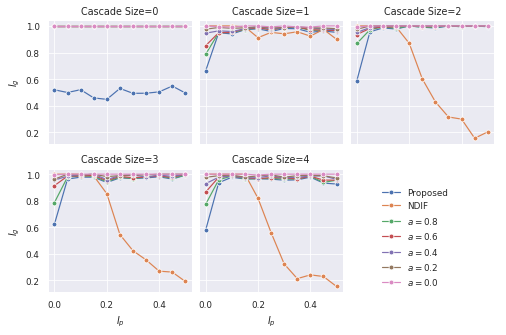

In [134]:
fig, ax = plt.subplots(2, 3, sharey='row', sharex='col', figsize=(8,5))

sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=x[x.cs == 0], ax=ax[0,0], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=x[x.cs == 1], ax=ax[0,1], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=x[x.cs == 2], ax=ax[0,2], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=x[x.cs == 3], ax=ax[1,0], marker='o', legend=False, ci=None)
sns.lineplot(x='ip', y='factor_detected', hue='Algo', data=x[x.cs == 4], ax=ax[1,1], marker='o', legend=False, ci=None)
ldg = fig.legend(loc=3, bbox_to_anchor=(0.65, 0.11), frameon=False, ncol=1, labels=['Proposed','NDIF','$a=0.8$','$a=0.6$','$a=0.4$', '$a=0.2$', '$a=0.0$'])
#ldg = fig.legend(loc=9, frameon=False, ncol=3, labels=['Proposed','Degree','Diffusion Degree', 'Degree Discount', 'PMIA', 'NDIF'])
ax[0][0].set(xlabel='$I_p$', ylabel='$I_g$')
ax[1][0].set(xlabel='$I_p$', ylabel='$I_g$')
ax[0][1].set(xlabel='$I_p$')
ax[1][1].set(xlabel='$I_p$')
ax[0][2].set(xlabel='$I_p$')

ax[0][0].set_title('Cascade Size=0')
ax[0][1].set_title('Cascade Size=1')
ax[0][2].set_title('Cascade Size=2')
ax[1][0].set_title('Cascade Size=3')
ax[1][1].set_title('Cascade Size=4')
#ax.set(xlabel='$I_p$', ylabel='fraction of gateway identified ($I_g$)')
#fig.savefig("graphics/compare_v_ip.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')
fig.delaxes(ax[1][2])
plt.subplots_adjust(hspace=0.2, wspace=0.05)
fig.savefig("graphics/compare_cascade_a.pdf", bbox_extra_artists=(ldg,), bbox_inches='tight')

### Some other graphs for simulations

In [33]:
g = nx.barabasi_albert_graph(151, 8)

In [45]:
nx.write_gexf(g, "datasets/Barabasi_Albert/network.gexf")

In [30]:
nx.info(net200)

'Name: \nType: Graph\nNumber of nodes: 148\nNumber of edges: 604\nAverage degree:   8.1622'

In [34]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 151\nNumber of edges: 1144\nAverage degree:  15.1523'

In [35]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

In [36]:
sns.distplot(degree_sequence)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [3]:
from PotHoleSim import Configs

In [84]:
import random

In [7]:
%%time
simulations = []
for ep in np.linspace(0,1,20,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'BA_e{0:.3f}_i{1:.3f}'.format(ep, ip)
        
        simulations.append(Configs.get_config('both_vary', name, "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/Barabasi_Albert/network.gexf",
                  {'prob_tv_spread': float(ep), 'prob_neighbor_spread': float(ip)}))

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 14 ms


##### Checking if the configs are different

In [8]:
simulations[1] == simulations[4]

False

In [ ]:
len(simulations)

#### Multiprocessing
As soil creates lot of threads internally, we can not use Dask which use DaemonProcess. We need a customization for NoDaemonProcess as below

In [6]:
def sim(cnf):
    soil.simulation.run_from_config(cnf, results_dir='soil_output/HA/Case1', dump=['gexf', 'csv'])
    return 1

##### Running simulations in parallel 

In [9]:
%%time
sim(simulations[0])

INFO:soil:Using config(s): BA_e0.050_i0.000
INFO:soil:Dumping results to soil_output/BA/Case1/BA_e0.050_i0.000 : ['gexf', 'csv']
INFO:soil:Starting simulation BA_e0.050_i0.000 at 1541795462.7259865.
INFO:soil:Starting Simulation BA_e0.050_i0.000 trial 0 at 1541795462.8834171.
INFO:soil:Finished Simulation BA_e0.050_i0.000 trial 0 in 16.47040343284607 seconds
INFO:soil:Starting Dumping simulation BA_e0.050_i0.000 trial 0 at 1541795479.3698068.
INFO:soil:Finished Dumping simulation BA_e0.050_i0.000 trial 0 in 12.690811395645142 seconds
INFO:soil:Dumping results to soil_output/BA/Case1/BA_e0.050_i0.000
INFO:soil:Finished simulation BA_e0.050_i0.000 in 30.647255897521973 seconds


CPU times: user 24 s, sys: 2.24 s, total: 26.2 s
Wall time: 31 s


1

In [ ]:
p = MyPool(8, maxtasksperchild=1)

#p.map(sim, simulations)

p.close()
p.join()

In [5]:
netBA = nx.read_gexf("datasets/Barabasi_Albert/network.gexf")
print(nx.info(netBA))

Name: 
Type: Graph
Number of nodes: 151
Number of edges: 1144
Average degree:  15.1523


In [6]:
simulations = []

for i in range(9,10):
    nodes = random.sample(list(netBA.nodes()), 10)
    
    dis = {}
    ep = 0.0
    
    for n in nodes:
        ep += 0.1
        dis[int(n)] = {'has_ext': 1, 'prob_tv_spread': float(ep)}
 

    for ip in np.linspace(0,1,20,endpoint=False):
        name = 'BAE_i{0:.3f}_{1}'.format(ip, i)               

        simulations.append(Configs.get_config('vary_p_e', name, "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/Barabasi_Albert/network.gexf",
                  {'prob_neighbor_spread': float(ip)}, states=dis))

In [16]:
simulations = []

for i in range(10):
    dis = {}
    
    for n in netBA.nodes():
        dis[int(n)] = {'prob_neighbor_spread': float(random.random())}

    for ep in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'BAV_e{0:.3f}_{1}'.format(ep, i)

        simulations.append(Configs.get_config('vary_p_i', name, "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/Barabasi_Albert/network.gexf",
                  {'prob_tv_spread': float(ep)}, states=dis))

In [17]:
len(simulations)

190

### Hamster

In [25]:
edge_list = pd.read_csv("datasets/hamster/out.petster-friendships-hamster-uniq", skiprows=1, sep=' ', header=None, names=['src', 'dst'])
netHamster = nx.from_pandas_edgelist(edge_list, source = 'src', target='dst')

In [27]:
nx.write_gexf(netHamster, "datasets/hamster/network.gexf")

In [28]:
nx.info(netHamster)

'Name: \nType: Graph\nNumber of nodes: 1858\nNumber of edges: 12534\nAverage degree:  13.4919'

In [4]:
%%time
simulations = []
for ep in np.linspace(0,1,20,endpoint=False):
    #print('ep: ', ep, ' Started')
    for ip in np.linspace(0,1,20,endpoint=False):
        if(ep == 0.0):
            continue
        name = 'HA_e{0:.3f}_i{1:.3f}'.format(ep, ip)
        
        file = 'soil_output/HA/Case1/{0}/{0}_trial_0.environment.csv'.format(name)
        if(os.path.exists(file)):
            continue
        
        
        simulations.append(Configs.get_config('both_vary', name, "/home/jovyan/work/nfs/suman/Project-1-external-influence-modeling/datasets/hamster/network.gexf",
                  {'prob_tv_spread': float(ep), 'prob_neighbor_spread': float(ip)}))

CPU times: user 22 ms, sys: 39 ms, total: 61 ms
Wall time: 163 ms
